In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import models, layers, regularizers, optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


### Wczytujemy dane z pliku *.csv
Użyty zestaw danych: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star

In [2]:
df = pd.read_csv("./data/pulsar_stars.csv")

### Wyświetlamy pięć pierwszych i pięć ostatnich próbek danych

In [3]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
df.tail()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0
17897,57.062500,85.797340,1.406391,0.089520,188.306020,64.712562,-1.597527,1.429475,0


### Sprawdzamy, czy w naszym zestawie danych występują braki 
Funkcja df.isnull().sum() przy każdym parametrze zwraca wartość 0 - to oznacza, że w naszym zestawie nie brakuje żadnych danych i możemy przejść do następnego kroku.

In [5]:
df.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

### Przedstawienie danych w formie histogramów każdej cechy

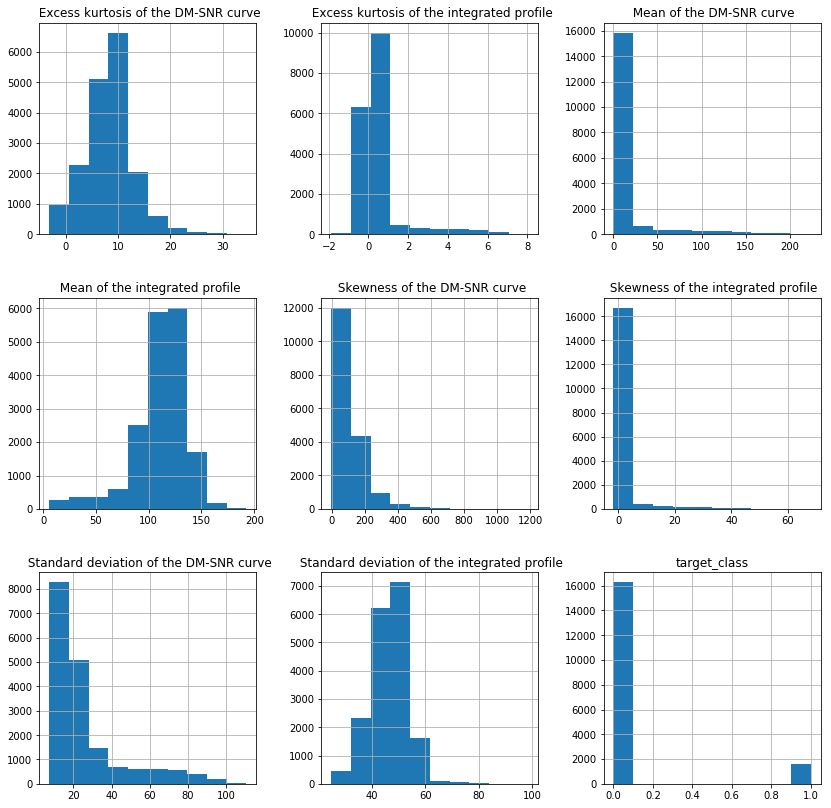

In [35]:
_ = df.hist(figsize=(14,14))

### Sprawdzamy liczebność poszcególnych klas
Jak widzimy poniżej, liczebność klasy 0 wynosi 16259 próbek, z kolei liczebność klasy 1 wynosi zaledwie 1639 próbek. Wynika z tego, że nasz zestaw danych zawiera niezbalansowane dane, co może prowadzić do niedokładnych wyników predykcji naszego modelu.
Aby temu zapobiec posłużymy się pojęciem oversamplingu, czyli nadpróbkowaniem klasy, która jest mniejszością.

In [7]:
X = df.drop("target_class", axis=1)
y = df.target_class
y.value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

Pomoże nam w tym funkcja SMOTE (Synthetic Minority Oversampling Technique) <br>
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

In [8]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X, y = smt.fit_sample(X, y)
np.bincount(y)

array([16259, 16259], dtype=int64)

### Dzielimy zestaw danych na zbiór treningowy i testowy

In [9]:
train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.25, shuffle=True)

In [10]:
print(train.shape, test.shape)

(24388, 8) (8130, 8)


### Normalizujemy dane przy użyciu standaryzacji

In [11]:
avg, std = np.zeros(train.shape[1]), np.zeros(train.shape[1])

In [12]:
for i in range(train.shape[1]):
    avg[i] = np.mean(train[:,i])
    std[i] = np.std(train[:,i])
train_normalized = (train-avg)/std
test_normalized = (test-avg)/std

### Tworzymy funkcje budującą model sieci
Dzięki temu możemy łatwo wywołać tę funkcję wiele razy tworząc kilka modeli (w tym przypadku do przedstawienia efektywności procesu uczenia na zbiorze znormalizowanym i "surowym".

In [22]:
def build():
    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape=(train_normalized.shape[1],)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
#     model.summary()
    
    return model

In [23]:
model = build()
model.summary()
len(model.layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_35 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1056      
__________

35

### Trenujemy sieć przy użyciu znormalizowanych danych

In [24]:
history = model.fit(train_normalized, train_labels, epochs=50, batch_size=256, validation_split=0.1, verbose=False)

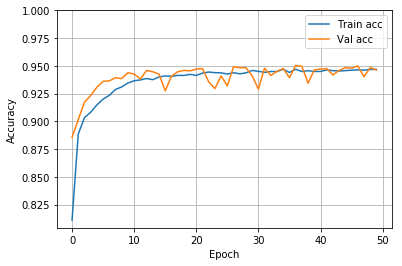

In [25]:
plt.plot(history.history['acc'], label='Train acc')
plt.plot(history.history['val_acc'], label='Val acc')
plt.legend()
plt.ylim(top=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

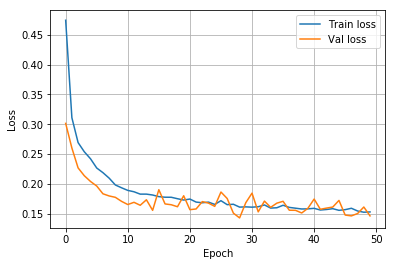

In [26]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [27]:
result = model.evaluate(test_normalized, test_labels, verbose=False)
train_result = model.evaluate(train_normalized, train_labels, verbose=0)

In [28]:
print("Train accuracy: ", train_result[1]*100, "\nTest accuracy: ", result[1]*100)

Train accuracy:  94.74331638510743 
Test accuracy:  94.7478474784748


In [29]:
model2 = build()

### Trenujemy sieć na "surowych" danych 

In [30]:
history2 = model2.fit(train, train_labels, epochs=50, batch_size=256, validation_split=0.1, verbose=False)

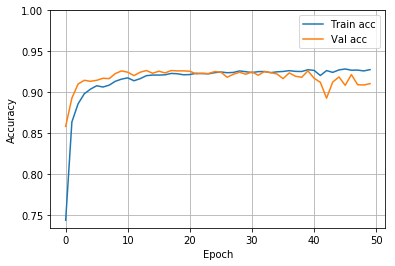

In [31]:
plt.plot(history2.history['acc'], label='Train acc')
plt.plot(history2.history['val_acc'], label='Val acc')
plt.legend()
plt.ylim(top=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

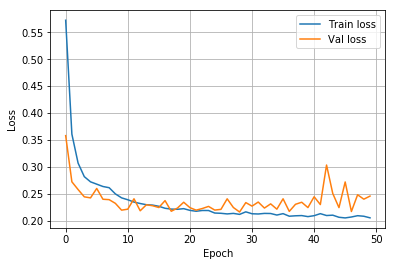

In [32]:
plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'], label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [33]:
result = model2.evaluate(test, test_labels, verbose=False)
train_result = model2.evaluate(train, train_labels, verbose=0)

In [34]:
print("Train accuracy: ", train_result[1]*100, "\nTest accuracy: ", result[1]*100)

Train accuracy:  92.05346891914056 
Test accuracy:  91.90651906519065


### Podsumowanie
W przypadku tego zestawu danych różnica w efektywności między siecią uczoną na danych surowych i siecią uczoną na danych znormalizowanych oscyluje na poziomie 1-2% na korzyść znormalizowanego zestawu danych, co może wydawać się niewielką różnicą w predykcji. Mogłoby się wydawać, że normalizacja danych nie robi tak dużej różnicy jakbyśmy się spodziewali. <br>
Nic bardziej mylnego - wszystko zależy od zestawu danych, który używamy do uczenia. Może się zdarzyć tak, że nasz zestaw danych będzie już znormalizowany, wtedy nasza efektywność będzie na wysokim poziomie bez dodatkowej normalizacji. Może się jednak zdarzyć tak, że zakresy wartości między poszczególnymi cechami będą się rożnić tysiąckrotnie bądź nawet bardziej, wtedy proces uczenia może się znacznie wydłużyć, a w skrajnych przypadkach uczenie może nie postępować wcale.